# Problem statement
Example 5.1 - Reinforcement Learning: An Introduction, Sutton and Barto, Second Edition - Monte Carlo

Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over.  They're playing against a fixed dealer.

Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and it's called 'usable' at 11.
This game is placed with an infinite deck. The game starts with dealer having one face up and one face down card, while player having two face up cards. The player can request additional cards (hit=1) until they decide to stop (stick=0) or exceed 21 (bust).

After the player sticks, the dealer reveals their facedown card, and draws until their sum is 17 or greater.  If the dealer goes bust the player wins.

If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, drawing is 0, and losing is -1.

The observation of a 3-tuple of: the players current sum (0-31), the dealer's one showing card (1-10 where 1 is ace),
and whether or not the player holds a usable ace (0 or 1).

In this notebook, we prediction the state value function from a sample_policy to play Blackjack card game.

In [1]:
import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 

from utils import plotting
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
env = gym.make('Blackjack-v1')

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [4]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

In [5]:
def monte_carlo_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm to calculate the value function
    for a given policy using sampling
    
    @policy: map of [state, action] representing the policy
    @env: OpenAI environment
    @num_episodes: Number of episodes to sample
    @discount_factor: Gamma discount factor
    
    Returns:
        A dictionary map from state -> value
    """
    # Keeps track of sum and count of returns to calculate 
    # the average return of each state
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    value = defaultdict(float)
    
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print(f"\rEpisode {i_episode}/{num_episodes}", end="")
            sys.stdout.flush()

        # Generate an episode: a tuple of (state, action, reward)
        episode = []
        state = env.reset()
        for t in range(20):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all states that were visited in this episode
        # (visited states are used later as dictionary keys)
        states_in_episode = set([tuple(x[0]) for x in episode])
        
        for state in states_in_episode:
            # Find the first occurance of the state in the episode
            first_occurence_ids = next(i for i,x in enumerate(episode) if x[0] == state)
            
            # Sum up all rewards after the first occurance
            rewards_after_first_occurance = [(i, x[2]) for i,x in enumerate(episode[first_occurence_ids:])]
            G = sum([x*(discount_factor**i) for i, x in rewards_after_first_occurance])
            
            # Calculate average return for this state over all sampled episodes
            returns_sum[state] += G
            returns_count[state] += 1.0
            value[state] = returns_sum[state] / returns_count[state]

    return value

Episode 500000/500000

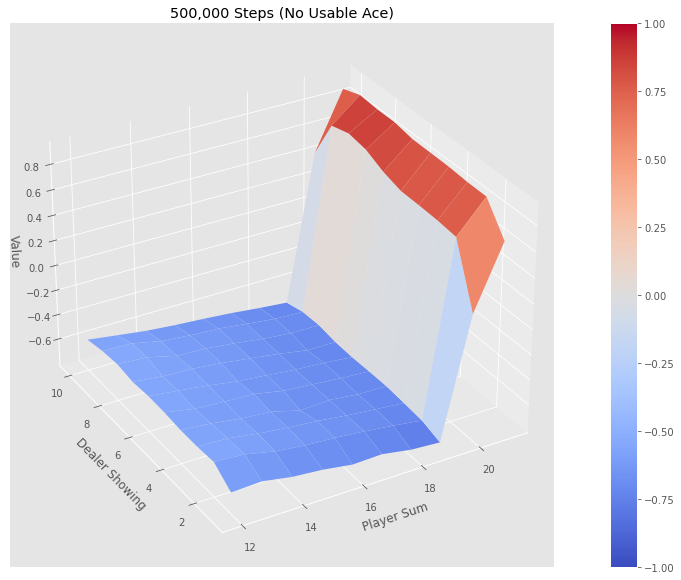

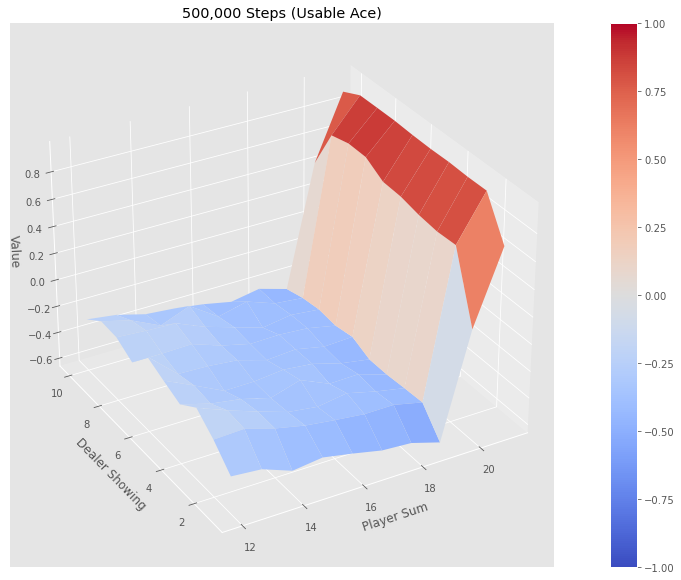

In [6]:
value_500k = monte_carlo_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(value_500k, title="500,000 Steps", minimum_x=12)